In [1]:
%env NUMBA_LOOP_VECTORIZE=0

env: NUMBA_LOOP_VECTORIZE=0


In [1]:
import numpy as np
import numba

In [2]:
numba.llvmlite.binding.llvm_version_info

(11, 1, 0)

In [3]:
mu = np.random.randn(10000)

In [4]:
@numba.njit()
def logp(x):
    out = 0.
    for i in range(len(x)):
        diff = x[i] - mu[i]
        out += (diff * diff) / 2
    return -out

sig = numba.types.void(
    numba.types.size_t,
    numba.types.CPointer(numba.types.float64),
    numba.types.CPointer(numba.types.float64),
)
@numba.cfunc(sig, nogil=True, boundscheck=False, no_cpython_wrapper=True, forceinline=True, error_model="numpy")
def logp(n_dim, out_, x_):
    out = numba.carray(out_, ())
    x = numba.carray(x_, (n_dim,))
    out[()] = logp(x)

In [5]:
with open("logp_func.ll", "w") as file:
    file.write(logp.inspect_llvm().replace(logp.native_name, "_logp_val"))

In [6]:
%%file test.c
#include <stdlib.h>

#define logp _logp_val

extern double __enzyme_autodiff(void*, size_t, double*, double*, double*, double*);
extern void logp(size_t, double*, double*);

int logp_grad(size_t n_dim, double *vals, double *grad, double *out, void* user_data) {
    double d_out = 1.;
    for (size_t i = 0; i < n_dim; i++) {
        grad[i] = 0;
    }
    __enzyme_autodiff((void*) logp, n_dim, out, &d_out, vals, grad);
    return 0;
}


Overwriting test.c


In [7]:
sig = numba.types.intc(
    numba.types.size_t,
    numba.types.CPointer(numba.types.float64),
    numba.types.CPointer(numba.types.float64),
    numba.types.CPointer(numba.types.float64),
    numba.types.voidptr,
)
@numba.cfunc(sig, forceinline=True, boundscheck=False, fastmath=True, nogil=True, error_model="numpy")
def val_grad(n_dim, x, grad, logp, user_data):
    #x = numba.carray(x_, (n_dim,))
    #grad = numba.carray(grad_, (n_dim,))
    #logp = numba.carray(logp_, ())
    
    logp_val = 0.
    for i in range(n_dim):
        #diff = x[i] - mu[i]
        diff = x[i]
        logp_val += diff * diff
        grad[i] = -diff
    logp[0] = -logp_val / 2
    return 0

In [8]:
#print(val_grad.inspect_llvm())

# Call make

In [9]:
#dim, x_, out_, logp_, user_data_

In [10]:
import nuts_py
import cffi
import fastprogress

In [11]:
ffi = cffi.FFI()

ffi.cdef("void logp_grad(size_t, size_t, size_t, size_t);")
lib = ffi.dlopen("./libgrad.so")
grad_address = int(ffi.cast("intptr_t", lib.logp_grad))

In [12]:
grad_address

140025188267344

In [13]:
grad_address = val_grad.address

In [13]:
def make_user_data():
    return 0

In [14]:
N = 10000
x = np.random.randn(N)

In [15]:
settings = nuts_py.lib.SamplerArgs()

In [16]:
n_chains = 4
n_draws = 1000
seed = 42
n_try_init = 10
n_tune = 1000

In [17]:
%%time
sampler = nuts_py.lib.ParallelSampler(grad_address, make_user_data, N, x, settings, n_chains=n_chains, n_draws=n_draws, seed=seed, n_try_init=10)

try:
    draws = np.full((n_chains, n_draws + n_tune, N), np.nan)
    infos = []
    for draw, info in fastprogress.progress_bar(sampler, total=n_chains * (n_draws + n_tune)):
        #for draw, info in sampler:
        infos.append(info)
        draws[info.chain, info.draw, :] = draw
finally:
    sampler.finalize()


CPU times: user 44 s, sys: 396 ms, total: 44.4 s
Wall time: 10.9 s


In [19]:
draws.nbytes / 1e6

640.0

In [64]:
info = infos[0]

In [25]:
tree_size = np.array([info.tree_size for info in infos])

505 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


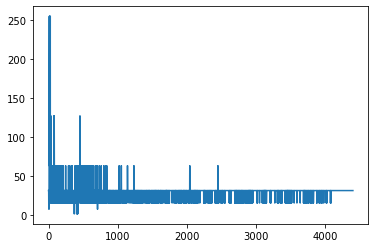

In [24]:
plt.plot(tree_size)

In [65]:
info.tree_size

31

In [63]:
len(infos)

8000

In [22]:
import matplotlib.pyplot as plt
import arviz

In [43]:
draws[0, :, 0]

array([ 0.25817805,  0.25817805, -0.42481754, ..., -0.20857555,
        1.85116314, -0.81571947])

In [44]:
mu[:10]

array([ 0.17211835, -0.68602856, -0.80353205,  0.52715001, -0.05462556,
       -1.62771054, -0.279306  ,  0.15304772,  0.6756206 , -0.69734878])

In [45]:
draws.mean(axis=0).mean(0)[:10]

array([ 0.17147715, -0.68147638, -0.80438107,  0.52673065, -0.06338274,
       -1.63440515, -0.27140571,  0.15522158,  0.67818006, -0.70148741])

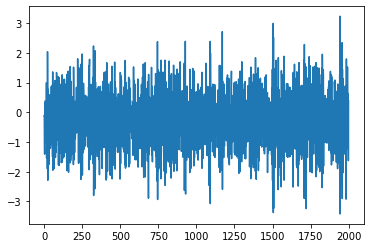

In [46]:
plt.plot(draws[0, :, 6]);

In [21]:
@numba.njit(nogil=True)
def call_grad(x, grad_out):
    logp = np.zeros(())
    grad_out[:] = 0
    logp_grad(len(x), logp.ctypes.data, x.ctypes.data, grad_out.ctypes.data)
    return logp[()]

In [22]:
x = np.random.randn(50000)

In [23]:
grad_out = np.zeros_like(x)

In [16]:
while True:
    call_grad(x, grad_out)

KeyboardInterrupt: 

In [17]:
%timeit call_grad(x, grad_out)

86.6 µs ± 322 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
v = np.zeros_like(x)

In [19]:
h = 1e-6
v[5] = h

In [20]:
out0 = np.zeros_like(grad_out)
out1 = np.zeros_like(grad_out)
logp1 = call_grad(x + v, out1)
logp0 = call_grad(x, out0)

In [21]:
(logp1 - logp0) / h

0.07005291990935802

In [22]:
out0[5]

0.07005453151266816